<figure>
<img src="../imagenes/logo-final-ap.png"  width="80" height="80" align="left"/> 
</figure>

# <span style="color:#4361EE"><left>Aprendizaje Profundo</left></span>

# <span style="color:red"><center>Diplomado en Inteligencia Artificial y Aprendizaje Profundo</center></span>

# <span style="color:green"><center>Audio to Image</center></span>

<figure>
<center>
<img src="../imagenes/onda_musical.gif" width=600 height= 400 align="center" />      
</center>
</figure>
<center>
<a href="https://commons.wikimedia.org/wiki/File:Forward_Scattering.gif">Jacopo Bertolotti</a>, CC0, via Wikimedia Commons
<center>

## <span style="color:#4361EE">Profesores</span>

1. Alvaro  Montenegro, PhD, ammontenegrod@unal.edu.co
1. Camilo José Torres Jiménez, Msc, cjtorresj@unal.edu.co
1. Daniel  Montenegro, Msc, dextronomo@gmail.com 

## <span style="color:#4361EE">Asesora Medios y Marketing digital</span>

4. Maria del Pilar Montenegro, pmontenegro88@gmail.com
5. Jessica López Mejía, jelopezme@unal.edu.co
6. Venus Puertas, vpuertasg@unal.edu.co

## <span style="color:#4361EE">Jefe Jurídica</span>

7. Paula Andrea Guzmán, guzmancruz.paula@gmail.com

## <span style="color:#4361EE">Coordinador Jurídico</span>

8. David Fuentes, fuentesd065@gmail.com

## <span style="color:#4361EE">Desarrolladores Principales</span>

9. Dairo Moreno, damoralesj@unal.edu.co
10. Joan Castro, jocastroc@unal.edu.co
11. Bryan Riveros, briveros@unal.edu.co
12. Rosmer Vargas, rovargasc@unal.edu.co

## <span style="color:#4361EE">Expertos en Bases de Datos</span>

13. Giovvani Barrera, udgiovanni@gmail.com
14. Camilo Chitivo, cchitivo@unal.edu.co

## <span style="color:#4361EE">Referencias</span>
1.  Jeremy Howard, Rachel Thomas and Francisco Ingham, <a href="https://jaredwinick.github.io/what_is_tf_keras/">What is tf.keras really?</a>


## <span style="color:#4361EE">Contenido</span>

* [Introducción](#Introducción)
* [Primeras Visualizaciones](#Primeras-Visualizaciones)
* [Audio a Imagen](#Audio-a-Imagen)
* [Mel Frequency Cepstral Coefficients](#Mel-Frequency-Cepstral-Coefficients)
* [Red Densa](#Red-Densa)

## <span style="color:#4361EE">Introducción</span>

El primer paso en cualquier sistema de reconocimiento de voz automático es extraer características, es decir, identificar los componentes de la señal de audio que son buenos para identificar el contenido lingüístico y descartar todas las demás cosas que transportan información como ruido de fondo, emoción, etc.

En esta ocasión, intentaremos hacer un clasificador de sonidos, usando el dataset **UrbanSound8K**. Existen varias formas de tratar este problema. Por ejemplo, podemos usar la extracción de features usando métodos de ingeniería para procesamiento de señales. Aquí veremos cómo tratar los audios desde el punto de vista de tratamiento de imágenes.

Es decir, **convertiremos un audio en imagen para su clasificación**. Primero haremos una red densa, y luego una convolucional para ver las diferencias en su precisión.

Importemos los paquetes necesarios:

In [1]:
#### Dependencies ####

import numpy as np
import pandas as pd
import librosa
import librosa.display

import matplotlib.pyplot as plt
from scipy.io import wavfile as wav
from sklearn import metrics 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Conv2D, MaxPooling2D,Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

## <span style="color:#4361EE">Primeras Visualizaciones</span>

El dataset asociado podrá ser encontrado en el drive del curso.

Visualicemos la metadata de nuestros archivos:

In [2]:
# Trabajar con datos desde el Zip
import tarfile
import os

#destino base de descompresión
base='/home/daniel/Data/Sound'
#camino de archivo descomprimido
camino=base+'/UrbanSound8K'

#Verificar si el path ya existe para evitar descomprensión
if os.path.isdir(camino):
    print("Ya se han descomprimido los archivos en: "+camino)
#Descomprimir en caso dado
else:
    local_tar = '/home/daniel/Data/Sound/UrbanSound8K.tar.gz'
    tar_ref   = tarfile.open(local_tar, 'r')
    tar_ref.extractall(base)
    tar_ref.close()

Ya se han descomprimido los archivos en: /home/daniel/Data/Sound/UrbanSound8K


In [3]:
# Load dataset metadata
df = pd.read_csv(camino+'/metadata/UrbanSound8K.csv')
df

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
...,...,...,...,...,...,...,...,...
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn


In [4]:
print(df[df.fold==1]['class'].unique())

['dog_bark' 'gun_shot' 'jackhammer' 'engine_idling' 'children_playing'
 'siren' 'street_music' 'air_conditioner' 'drilling' 'car_horn']


Tomemos, por ejemplo, un audio de cada clase y miremos cómo luce

In [5]:
# Create a list of the class labels
labels = list(df['class'].unique())

# Let's grab a single audio file from each class
files = dict()

for i in range(len(labels)):
    tmp = df[df['class'] == labels[i]][:1].reset_index()
    path = camino+'/audio/fold{}/{}'.format(tmp['fold'][0], tmp['slice_file_name'][0])
    files[labels[i]] = path

In [6]:
print(labels)

['dog_bark', 'children_playing', 'car_horn', 'air_conditioner', 'street_music', 'gun_shot', 'siren', 'engine_idling', 'jackhammer', 'drilling']


In [7]:
files

{'dog_bark': '/home/daniel/Data/Sound/UrbanSound8K/audio/fold5/100032-3-0-0.wav',
 'children_playing': '/home/daniel/Data/Sound/UrbanSound8K/audio/fold5/100263-2-0-117.wav',
 'car_horn': '/home/daniel/Data/Sound/UrbanSound8K/audio/fold10/100648-1-0-0.wav',
 'air_conditioner': '/home/daniel/Data/Sound/UrbanSound8K/audio/fold5/100852-0-0-0.wav',
 'street_music': '/home/daniel/Data/Sound/UrbanSound8K/audio/fold7/101848-9-0-0.wav',
 'gun_shot': '/home/daniel/Data/Sound/UrbanSound8K/audio/fold1/102305-6-0-0.wav',
 'siren': '/home/daniel/Data/Sound/UrbanSound8K/audio/fold7/102853-8-0-0.wav',
 'engine_idling': '/home/daniel/Data/Sound/UrbanSound8K/audio/fold10/102857-5-0-0.wav',
 'jackhammer': '/home/daniel/Data/Sound/UrbanSound8K/audio/fold1/103074-7-0-0.wav',
 'drilling': '/home/daniel/Data/Sound/UrbanSound8K/audio/fold3/103199-4-0-0.wav'}

Una vez elegidos, veamos su representación gráfica en terminos temporales y de amplitud.

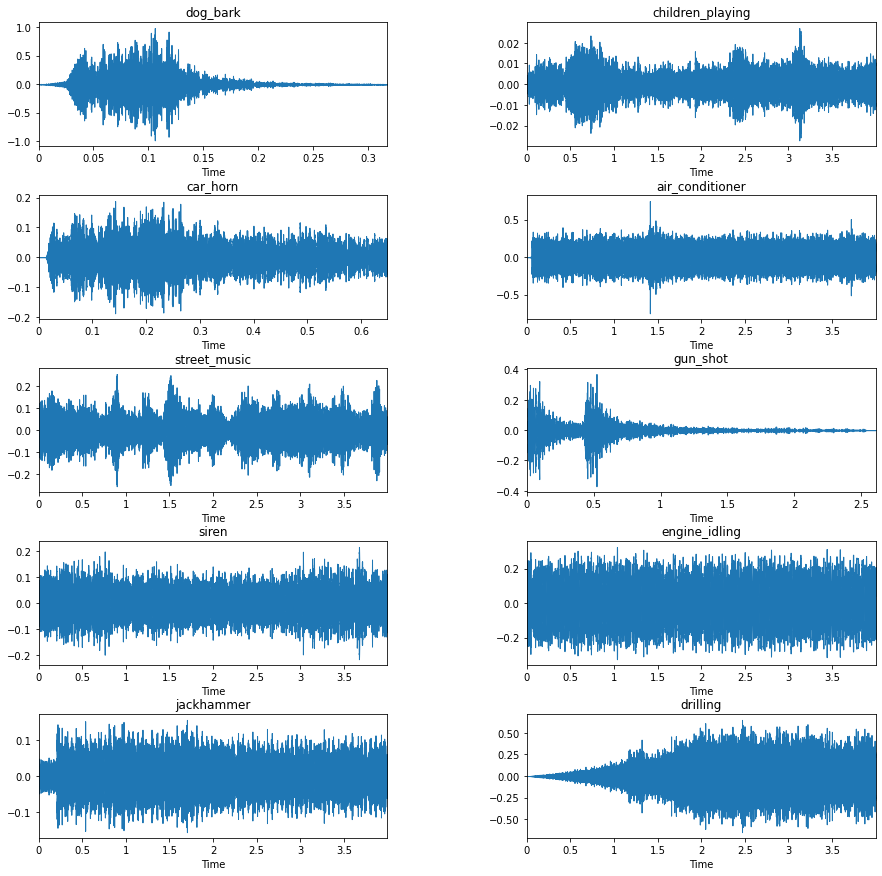

In [8]:
fig = plt.figure(figsize=(15,15))

fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, label in enumerate(labels):
    
    #Elegimos un archivo
    fn = files[label]
    
    fig.add_subplot(5, 2, i+1)
    
    plt.title(label)
    
    #Hacemos uso de librosa para leer audio
    data, sample_rate = librosa.load(fn)
    #usamos el visualizador de librosa
    librosa.display.waveplot(data, sr= sample_rate)

plt.savefig('class_examples.png')

Como podemos observar, cada audio se puede entender como una serie de tiempo en un intervalo fijo de tiempo.

Desde este punto, no es muy claro si construir una red de clasificación podrá discernir las diferencias entre las clases de sonidos.

Algo importante para tener en cuenta:

**Sampling Rate:** Es la tasa a la que se muestrea una señal. Más alto y se perderá menos información. Más bajo y se tendrá menos detalle.

Veamos un ejemplo:

In [10]:
audios_fold1=os.listdir(camino+'/audio/fold1')

azar=np.random.randint(len(audios_fold1))

fn = camino+'/audio/fold1/'+audios_fold1[azar]

librosa_audio, librosa_sample_rate = librosa.load(fn)

scipy_sample_rate, scipy_audio = wav.read(fn)

print("Original sample rate: {}".format(scipy_sample_rate))
print("Librosa sample rate : {}".format(librosa_sample_rate))

Original sample rate: 48000
Librosa sample rate : 22050


De la metadata, veamos de qué audio se trata.

In [11]:
df[df['slice_file_name']==audios_fold1[azar]]

,slice_file_name,fsID,start,end,salience,fold,classID,class
6523,46669-4-0-31.wav,46669,15.5,19.5,1,1,4,drilling


Veamos los datos en bruto:

In [12]:
print(librosa_audio)

[ 0.02765657 -0.15591285  0.14167398 ...  0.03113969 -0.00044506
  0.02256561]


In [13]:
print("Cuántos Datos librosa: ",len(librosa_audio),'Hz')
print("Cuántos Datos Scipy  : ",len(scipy_audio),'Hz')

Cuántos Datos librosa:  88200 Hz
Cuántos Datos Scipy  :  192000 Hz


In [14]:
print('Duración Audio: {:3.2f} segundos'.format(len(librosa_audio)/librosa_sample_rate))

Duración Audio: 4.00 segundos


Como podemos observar, las tasas de muestreo son diferentes cuando usamos librosa.

Esto es bueno, desde el punto de vista de eficiencia computacional.

El default en librosa es un subsampling a 22050 Hz. Esto puede ser amnipulado con los parámetros de load.

In [15]:
print('Original audio file min~max range: {} to {}'.format(np.min(scipy_audio), np.max(scipy_audio)))
print('Librosa audio file min~max range: {} to {}'.format(np.min(librosa_audio), np.max(librosa_audio)))

Original audio file min~max range: -9871 to 8663
Librosa audio file min~max range: -0.258188933134079 to 0.2836798429489136


Escuchemos:

In [16]:
from IPython.display import Audio

Audio(librosa_audio, rate=librosa_sample_rate)

In [17]:
Audio(scipy_audio[:,0], rate=scipy_sample_rate)

Reproducción a dos canales:

In [18]:
#Need to install sounddevice
import sounddevice as sd
sd.play(scipy_audio)
# Wait until file is done playing
status = sd.wait() 

**¿Notan alguna Diferencia?**

In [19]:
print(scipy_audio.shape)

(192000, 2)


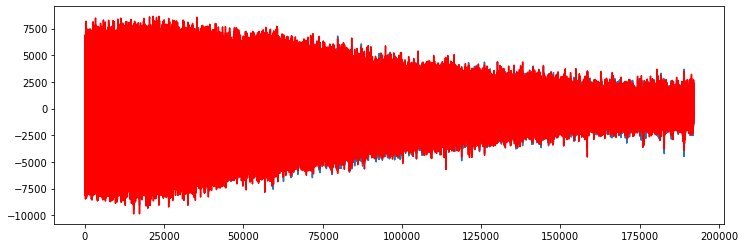

In [20]:
plt.figure(figsize=(12, 4))
plt.plot(scipy_audio[:,0])
plt.plot(scipy_audio[:,1],'r')
plt.savefig('original_audio.png')

El audio desde scipy contiene dos canales (Stereo) y las señales no son idénticas.

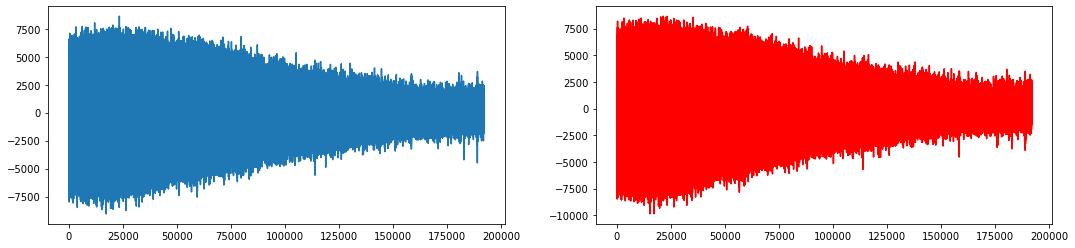

In [21]:
plt.figure(figsize=(18, 4))
plt.subplot(121)
plt.plot(scipy_audio[:,0])
plt.subplot(122)
plt.plot(scipy_audio[:,1],color='red')
plt.show()

Por otro lado, librosa deja un único canal para procesamiento directo.

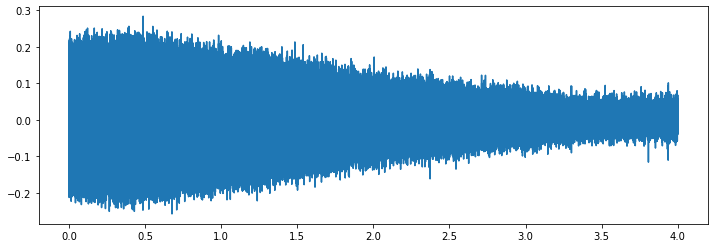

In [22]:
time = np.arange(0, len(librosa_audio)) / librosa_sample_rate
# Librosa: mono track
plt.figure(figsize=(12,4))
plt.plot(time,librosa_audio)
plt.savefig('librosa_audio.png')

## <span style="color:#4361EE">Transformada de Fourier</span>

A simple vista, no se ven detalles importantes de la señal.

Una herramienta muy importante para ver esos detalles escondidos (espectro), se llama la **Transformada de Fourier.**

Matemáticamente hablando, la transformada de Fourier de un audio es una función definida como:

$$g(\xi)=\int_{-\infty}^{\infty}x(t)e^{-i\xi t}dt$$

Simplificando e interpretando un poco, la transformada de Fourier trata de ver qué **contenido de frecuencias** de funciones periódicas sinusoidales están presentes en la señal.

En términos Wikipedia,

*La transformada de Fourier es básicamente el espectro de frecuencias de una función. Un buen ejemplo de eso es lo que hace el oído humano, ya que recibe una onda auditiva y la transforma en una descomposición en distintas frecuencias (que es lo que finalmente se escucha). El oído humano va percibiendo distintas frecuencias a medida que pasa el tiempo, sin embargo, la transformada de Fourier contiene todas las frecuencias del tiempo durante el cual existió la señal; es decir, en la transformada de Fourier se obtiene un solo espectro de frecuencias para toda la función.* [[Wiki]](https://es.wikipedia.org/wiki/Transformada_de_Fourier#Definición)


Veamos un ejemplo:

Para una visualización de cómo funciona la transformada de Fourier, podemos consultar el siguiente [GIF de Wiki](https://upload.wikimedia.org/wikipedia/commons/7/72/Fourier_transform_time_and_frequency_domains_%28small%29.gif)

Una poderosa implementación de la Transformada de Fourier en forma discreta (DFT) se llama **fft** (Fast Fourier Transform)

La fórmula matemática de la DFT es:

$$X_k = \sum_{n=0}^{N-1}x[n]e^{-\frac{2\pi i}{N}kn}$$

En scipy podemos encontrar una implementación. [Documentación](https://docs.scipy.org/doc/scipy/reference/tutorial/fft.html)

La explicación detallada de esta implementación está fuera del alcance de este curso, pero pueden consultar [aquí](https://es.wikipedia.org/wiki/Transformada_r%C3%A1pida_de_Fourier) para iluminar ideas.

Duración señal: 0.75 segs


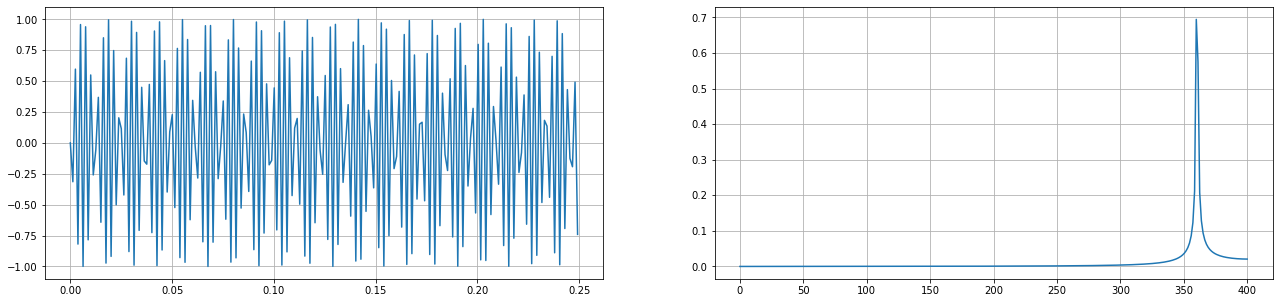

In [23]:
from scipy.fft import fft

#Numero de Muestras
N = 600
# Periodo de muestreo
T = 1.0 / 800
# Frecuencia de señal de ejemplo
f1=440.
# π bonito :)
π=np.pi

print("Duración señal:",N*T,'segs')


#Tiempo de muestreo
x=np.linspace(0,N*T,N)
#Señal muestreada
y=np.sin(f1*2*π*x)

#Transformada de Fourier
Tfy=fft(y)
#Dominio de Frecuencias
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

plt.figure(figsize=(22,5))
plt.subplot(121)
plt.plot(x[0:200],y[0:200])
plt.grid()
plt.subplot(122)
plt.plot(xf, 2.0/N *np.abs(Tfy[0:N//2]))
plt.grid()
plt.show()

In [24]:
Audio(y, rate=1/T)

Veamos un ejemplo más "complicado" (Simulado, sin embargo):

Duración señal: 1.0 segs


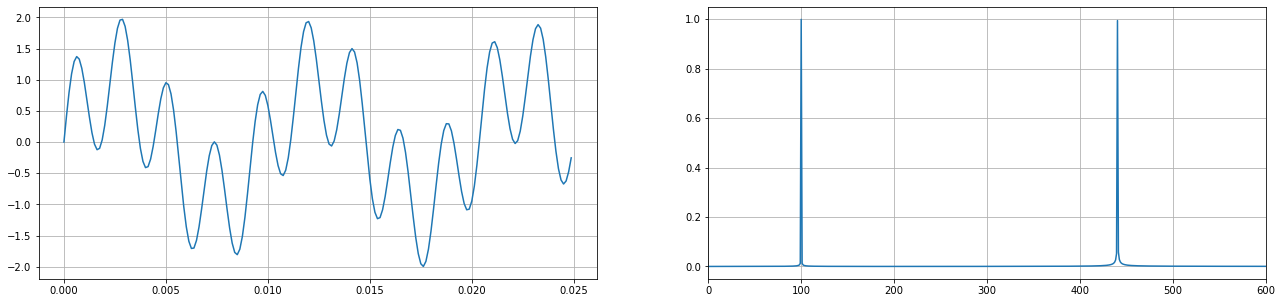

In [25]:
#Numero de Muestras
N = 8000
# Periodo de muestreo
T = 1.0 / 8000
# Frecuencia de señal de ejemplo
f1=440.
f2=100.
# π bonito :)
π=np.pi

print("Duración señal:",N*T,'segs')


#Tiempo de muestreo
x=np.linspace(0,N*T,N)
#Señal muestreada
y=np.sin(f1*2*π*x)+np.sin(f2*2*π*x)

#Transformada de Fourier
Tfy=fft(y)
#Dominio de Frecuencias
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

plt.figure(figsize=(22,5))
plt.subplot(121)
plt.plot(x[0:200],y[0:200])
plt.grid()
plt.subplot(122)
plt.plot(xf, 2.0/N *np.abs(Tfy[0:N//2]))
plt.xlim([0,600])
plt.grid()
plt.show()

Note el número de puntos que sale de la FFT:

In [26]:
len(Tfy)

8000

In [27]:
Audio(y, rate=1/T)

**¿Quieres tus propios Ejemplos?**

**¡Se le tiene!**

In [28]:
import sounddevice as sd
from scipy.io.wavfile import write

fs = 44100  # Sample rate
seconds = 12  # Duration of recording

myrecording = sd.rec(int(seconds * fs), samplerate=fs, channels=2)
sd.wait()  # Wait until recording is finished
write('output.wav', fs, myrecording)  # Save as WAV file 

In [29]:
Audio(myrecording[:,0], rate=fs)

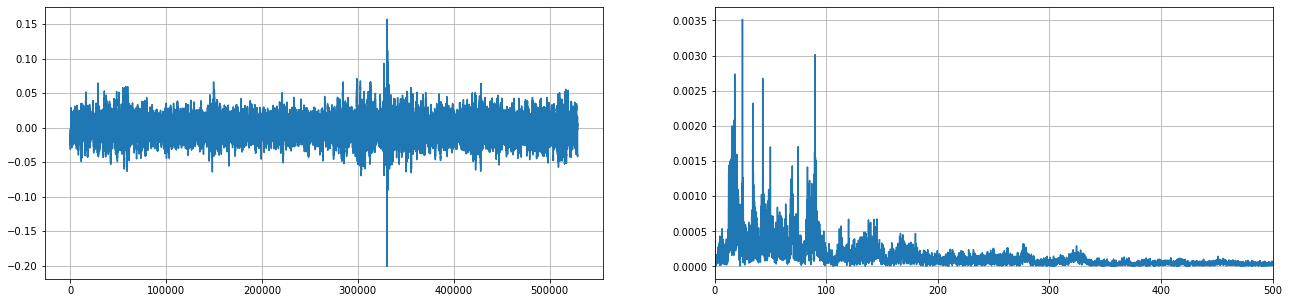

In [30]:
N=len(myrecording[:,0])
#Transformada de Fourier
Tfy=fft(myrecording[:,0])
#Dominio de Frecuencias
xf = np.linspace(0.0, 1.0/(2.0*1/fs), N//2)

#Plotting dibujitos
plt.figure(figsize=(22,5))
plt.subplot(121)
plt.plot(myrecording[:,0])
plt.grid()
plt.subplot(122)
plt.plot(xf, 2.0/N *np.abs(Tfy[0:N//2]))
plt.xlim([0,500])
plt.grid()
plt.show()

Apliquemos la TF a nuestro audio elegido del Dataset:

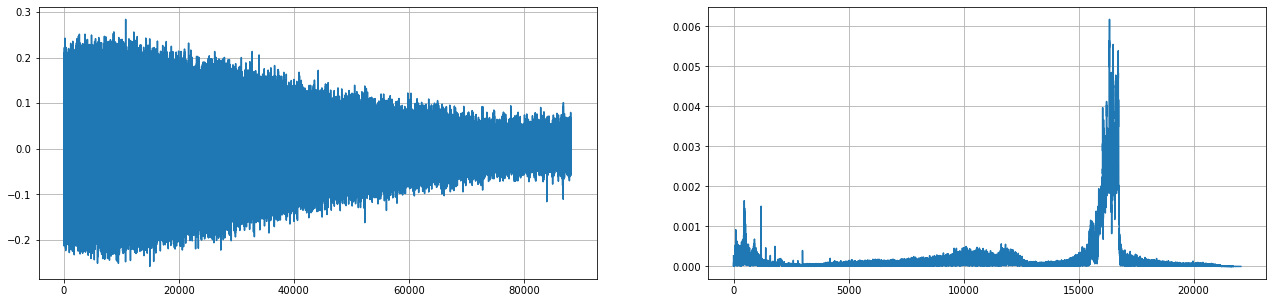

In [31]:
N=len(librosa_audio)
#Transformada de Fourier
Tfy=fft(librosa_audio)
#Dominio de Frecuencias
xf = np.linspace(0.0, 1.0/(2.0*1/fs), N//2)

#Plotting dibujitos
plt.figure(figsize=(22,5))
plt.subplot(121)
plt.plot(librosa_audio)
plt.grid()
plt.subplot(122)
plt.plot(xf, 2.0/N *np.abs(Tfy[0:N//2]))
plt.grid()
plt.show()

El estudiante puede imaginarse la cantidad asombrosa de aplicaciones que tiene la transformada de Fourier.

Entre algunas poderosas aplicaciones, tenemos:

- Soluciones de Ecuaciones Diferenciales Parciales.
- Procesamiento de Señales Digitales (Música, Ingeniería, etc)
- Procesamiento de Imágenes (Generación de filtros)

**En particular, para nuestro curso en IA y AP, haremos uso de una versión local de la TF para convertir nuestros audios a imágenes :)**

## <span style="color:#4361EE">Transformada de Fourier de Tiempo Reducido (STFT)</span>

La STFT (Short-Term-Fourier-Transform) es *usada para determinar el contenido en frecuencia sinusoidal y de fase en **secciones locales** de una señal así como sus cambios con respecto al tiempo*. [[1]](https://es.wikipedia.org/wiki/Transformada_de_Fourier_de_Tiempo_Reducido)

Lo que esto quiere decir es que la STFT puede analizar contenidos de frecuencias en partes determinadas de la señal, algo parecido a reconocimiento de patrones.

Como queremos convertir un audio a imagen, es súper interesante poder ver las partes importantes del audio de manera local.

**El secreto detrás de todo esto radica en la convolución:**

$$STFT\{x[n]\}=X(m,\omega)=\sum_{n=-\infty}^{\infty}x[n]k[n-m]e^{-j\omega n}$$

La anterior es la STFT de una señal discreta.

Lo que ocurre es que $k$ es una ventana (kernel) que es cero para casi todos los valores excepto por una porción pequeña del dominio.

Esto hace que se realice la **Transformada de Fourier en secciones locales de la señal**.

Observe atentamente que sin la exponencial presente, recuperamos la definición de convolución entre una señal y un filtro.

Lo importante es que, ahora tenemos un objeto en 2-dimensiones, y esto podemos visualizarlo.

**¡Listo, ya tenemos las herramientas necesarias para ver las radiografías de nuestros audios!**

## <span style="color:#4361EE">Audio a Imagen</span>

Para generar información sobre todo el archivo, podemos tomar una FFT de una ventana de 1024 muestras y deslizarla por 512 muestras (longitud de salto, hop-length) para que las ventanas se superpongan entre sí.

Esto se llama Transformada de Fourier a corto plazo (STFT) y nos permite ver cómo cambian las diferentes frecuencias con el tiempo.

Para la documentación de STFT, ir [aquí](https://librosa.org/doc/latest/generated/librosa.stft.html).

Forma de la imagen: (513, 173) 



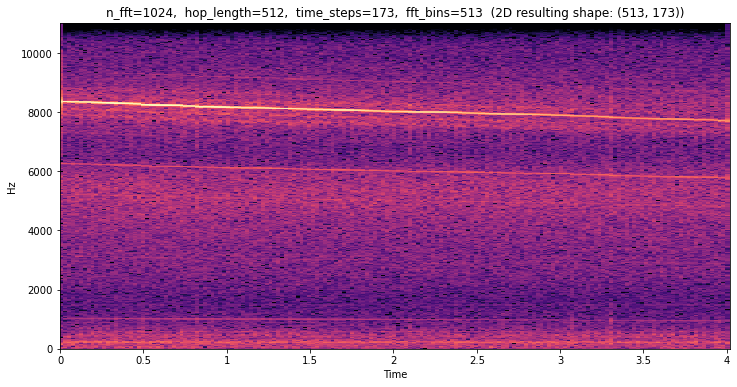

In [32]:
hop_length = 512
n_fft = 1024 # frame length 

#Short-Time-Fourier-Transform
stft = librosa.stft(librosa_audio, n_fft=n_fft, hop_length=hop_length)

#Separar resultado en parte de magnitud y fase
stft_magnitude, stft_phase = librosa.magphase(stft)
print("Forma de la imagen:",stft_magnitude.shape,'\n')

# Pasar amplitud a decibeles para espectrograma
stft_magnitude_db = librosa.amplitude_to_db(stft_magnitude, ref=np.max)

plt.figure(figsize=(12, 6))

#Mostrar Espectrograma
librosa.display.specshow(stft_magnitude_db, x_axis='time', y_axis='linear', 
                         sr=librosa_sample_rate, hop_length=hop_length)

title = 'n_fft={},  hop_length={},  time_steps={},  fft_bins={}  (2D resulting shape: {})'
plt.title(title.format(n_fft, hop_length, 
                       stft_magnitude_db.shape[1], 
                       stft_magnitude_db.shape[0], 
                       stft_magnitude_db.shape));

La imagen anterior no muestra con precisión cómo los humanos perciben las frecuencias.

Junto con el volumen, también escuchamos frecuencias en una escala logarítmica. 

Oiríamos la misma "distancia" de frecuencias de 50 Hz a 100 Hz que escucharíamos entre 400 Hz y 800 Hz. 

Estas son algunas de las razones por las cuales muchas personas usan melspectrograms que transforman los intervalos de frecuencia en la escala mel.

Librosa nos permite convertir fácilmente un espectrograma regular en un electrograma milimétrico, y nos permite definir cuántos "bins" queremos tener.

También podemos especificar una frecuencia mínima y máxima en la que queremos que nuestros contenedores se dividan.

## <span style="color:#4361EE">Mel Frequency Cepstral Coefficients</span>

### <span style="color:#4CC9F0">¿Qué es la escala de Mel?</span>

La escala Mel relaciona la frecuencia percibida, o tono, de un tono puro con su frecuencia medida real.

Los seres humanos son mucho mejores para discernir pequeños cambios de tono a bajas frecuencias que a altas frecuencias. 

La incorporación de esta escala hace que nuestras características coincidan más con lo que escuchan los humanos.

La fórmula para convertir de frecuencia a escala Mel es:

$$M(f)=1125 \ln\biggl(1+\frac{f}{700}\biggr)$$

Claramente, para volver a escala de frecuencia, se debería usar la fórmula

$$M^{-1}(m)=700(e^{\frac{m}{1125}}-1)$$


El punto principal para entender sobre el habla es que los sonidos generados por un humano son filtrados por la forma del tracto vocal, incluyendo lengua, dientes, etc. 

Esta forma determina qué sonido sale. 

Si podemos determinar la forma con precisión, esto debería darnos una representación precisa del fonema que se está produciendo. 

La forma del tracto vocal se manifiesta en la envolvente del espectro de potencia de tiempo corto, y el trabajo de los MFCC es representar con precisión esta envolvente.

Una forma útil de visualizar el MFCC es usando el melspectrogram que brinda librosa.

Veamos el ejemplo con nuestros audios elegido:

/home/daniel/anaconda3/envs/tf2/lib/python3.8/site-packages/librosa/filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(
/home/daniel/anaconda3/envs/tf2/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/home/daniel/anaconda3/envs/tf2/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


(100, 173)


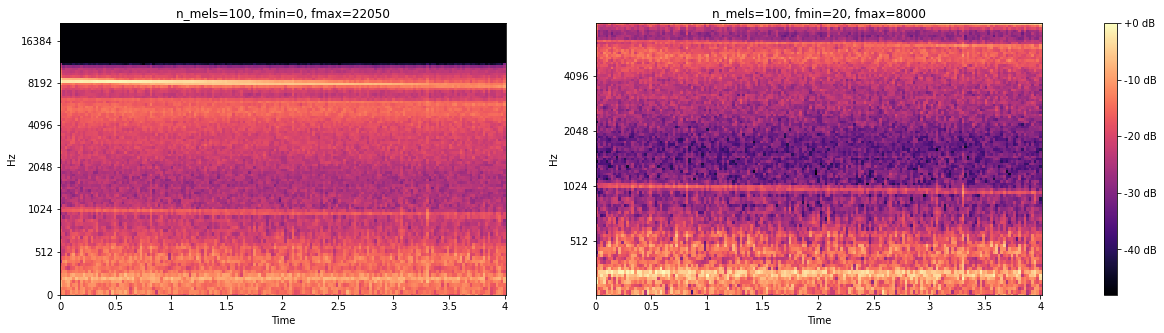

In [33]:
# number of mel frequency bands 
n_mels = 100

fig, ax = plt.subplots(1, 2, figsize=(22, 5))

fmin = 0            
fmax = 22050 # sample_rate/2

mel_spec = librosa.feature.melspectrogram(librosa_audio, n_fft=n_fft, hop_length=hop_length,
                                          n_mels=n_mels, sr=librosa_sample_rate, power=1.0,
                                          fmin=fmin, fmax=fmax)

mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)

img=librosa.display.specshow(mel_spec_db, x_axis='time',  y_axis='mel', 
                         sr=librosa_sample_rate, hop_length=hop_length, 
                         fmin=fmin, fmax=fmax, ax=ax[0])


ax[0].set_title('n_mels='+str(n_mels)+', fmin=0, fmax=22050')

print(mel_spec_db.shape)


fmin = 20           
fmax = 8000
mel_spec = librosa.feature.melspectrogram(librosa_audio, n_fft=n_fft, hop_length=hop_length,
                                          n_mels=n_mels, sr=sample_rate, power=1.0, 
                                          fmin=fmin, fmax=fmax)

mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)

img2=librosa.display.specshow(mel_spec_db, x_axis='time',  y_axis='mel', 
                         sr=sample_rate, hop_length=hop_length, 
                         fmin=fmin, fmax=fmax, ax=ax[1])
ax[1].set_title('n_mels='+str(n_mels)+', fmin=20, fmax=8000')
fig.colorbar(img2, ax=ax, format='%+2.0f dB')
plt.show()

Link Bastante Útil: 
    
[Getting to Know the Mel Spectrogram](https://towardsdatascience.com/getting-to-know-the-mel-spectrogram-31bca3e2d9d0).

**Nota Final Antes de la Magia:** Interesante ver que este es un proceso bastante artesanal. 

¿Podríamos pensar en una red neuronal que nos tome la mejor imagen de nuestro audio para luego procesarlo en otra red de clasificación?

## <span style="color:#4361EE">Extrayendo Imágenes de los Audios</span>

Generemos una rutina que nos procese el MFCC para cada audio por separado:

In [55]:
def extract_features(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    fmin = 20            
    fmax = 8000 # sample_rate/2
    
    #Usando mels
    mel_spec = librosa.feature.melspectrogram(audio, n_fft=n_fft, hop_length=hop_length,
                                          n_mels=n_mels, sr=sample_rate, power=1.0,
                                          fmin=fmin, fmax=fmax)

    mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)
    mel_mean=np.mean(mel_spec_db.T,axis=0)
    
    #Usando mfccs
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_processed = np.mean(mfccs.T,axis=0)
    
    return mel_spec_db,mel_mean,mfccs_processed

In [56]:
import os

features = []

fulldatasetpath=camino+'/audio'

# Iterate through each sound file and extract the features 
for index, row in df.iterrows():
    
    file_name = os.path.join(os.path.abspath(fulldatasetpath),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    
    class_label = row["class"]
    data,data_mean,data_mean_mfcc = extract_features(file_name)
    
    features.append([data,data_mean,data_mean_mfcc,class_label])

/home/daniel/anaconda3/envs/tf2/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1323
  warnings.warn(
/home/daniel/anaconda3/envs/tf2/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1103
  warnings.warn(
/home/daniel/anaconda3/envs/tf2/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1523
  warnings.warn(


In [57]:
print(len(features))
# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(features, columns=['feature','mean_feature','mean_feature_mfcc','class_label'])

8732


In [58]:
featuresdf.head()

,feature,mean_feature,mean_feature_mfcc,class_label
0,"[[-64.01678, -70.206985, -67.451515, -66.56778...","[-67.28726, -62.524014, -60.975414, -63.869774...","[-215.79301, 71.66612, -131.81377, -52.091328,...",dog_bark
1,"[[-13.355013, -7.4238873, -20.003115, -12.5514...","[-10.663073, -11.62883, -12.551069, -18.00609,...","[-424.68677, 110.56227, -54.148235, 62.01073, ...",children_playing
2,"[[-20.97464, -10.614773, -6.3526573, -18.64971...","[-13.6652565, -12.984228, -14.145984, -20.3103...","[-459.56467, 122.800354, -47.92471, 53.265694,...",children_playing
3,"[[-8.950098, -12.449125, -14.900068, -14.45273...","[-15.553438, -15.03913, -14.272235, -17.148026...","[-414.55377, 102.896904, -36.66495, 54.18041, ...",children_playing
4,"[[-4.737808, -3.8283405, -8.629837, -7.087017,...","[-7.3960934, -10.642873, -10.760186, -14.21860...","[-447.397, 115.0954, -53.809113, 61.608585, 1....",children_playing


In [59]:
featuresdf.to_csv("Data_Audio_Image.csv")

In [60]:
featuresdf.iloc[0]['mean_feature'].shape

(100,)

In [61]:
featuresdf.iloc[0]['feature'].shape

(100, 14)

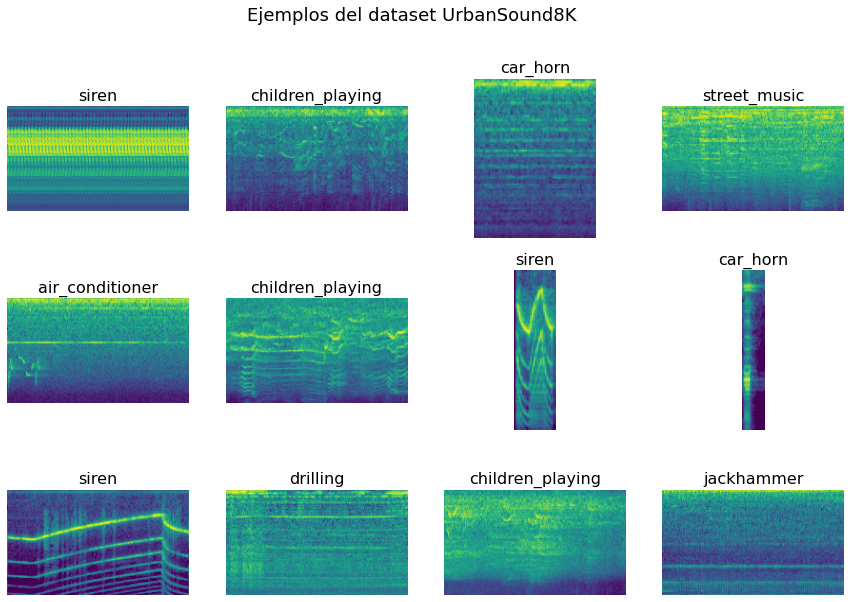

In [62]:
#Cuántas filas
filas=3
#Cuantas columnas
colus=4
#Elementos totales
n=filas*colus
#Elegir una muestra del dataset via índices
vector_azar=np.random.randint(len(featuresdf.feature),size=(n,))
# contador para dibujar en la grilla
w=1
#iniciar espacio de dibujo
plt.figure(figsize=(15,10))
#titulo
plt.suptitle("Ejemplos del dataset UrbanSound8K",fontsize=18)

# Loop anidado para recorrer la matriz completa
for i in range(filas):
    for j in range(colus):
        
        # subplots se peden contar incrementalmente
        plt.subplot(filas,colus,w)
        # dibujar el ejemplo de la muestra convertida a una matrix 28X28
        plt.imshow(featuresdf.feature[vector_azar[w-1]])
        #mostrar la etiqueta dada por el humano a dicho ejemplo (Aprendizaje supervisado)
        plt.title(featuresdf.class_label[vector_azar[w-1]],fontsize=16)
        #No mostrar ejes corrdenados
        plt.axis("off")
        # Incrementar contador
        w+=1

plt.show()

## <span style="color:#4361EE">Usando Promedios de las imágenes</span>

In [63]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.mean_feature_mfcc.tolist())
y = np.array(featuresdf.class_label.tolist())
# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y))

In [64]:
# split the dataset 
from sklearn.model_selection import train_test_split 
x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 127)

In [65]:
x_train.shape

(6985, 40)

## <span style="color:#4361EE">Red Densa</span>

In [66]:
num_labels = yy.shape[1]

def build_model_graph(input_shape=(100,)):
    
    
    model = Sequential()
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_labels))
    model.add(Activation('softmax'))
    # Compile the model
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
    return model

model = build_model_graph()

In [67]:
# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=0)
accuracy = 100*score[1]

# Display model architecture summary 
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              multiple                  10496     
_________________________________________________________________
activation_6 (Activation)    multiple                  0         
_________________________________________________________________
dropout_4 (Dropout)          multiple                  0         
_________________________________________________________________
dense_7 (Dense)              multiple                  65792     
_________________________________________________________________
activation_7 (Activation)    multiple                  0         
_________________________________________________________________
dropout_5 (Dropout)          multiple                  0         
_________________________________________________________________
dense_8 (Dense)              multiple                 

In [68]:
print("Pre-training accuracy: %.4f%%" % accuracy)

Pre-training accuracy: 4.5793%


In [69]:
from tensorflow.keras.callbacks import ModelCheckpoint 
from datetime import datetime 
num_epochs = 100
num_batch_size = 32
model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), verbose=1)

Epoch 1/100
219/219 [==============================] - 3s 12ms/step - loss: 9.1935 - accuracy: 0.1745 - val_loss: 2.1876 - val_accuracy: 0.1809
Epoch 2/100
219/219 [==============================] - 3s 13ms/step - loss: 2.2869 - accuracy: 0.2255 - val_loss: 2.1017 - val_accuracy: 0.2679
Epoch 3/100
219/219 [==============================] - 2s 9ms/step - loss: 2.0796 - accuracy: 0.2806 - val_loss: 1.8842 - val_accuracy: 0.3446
Epoch 4/100
219/219 [==============================] - 2s 9ms/step - loss: 1.9150 - accuracy: 0.3224 - val_loss: 1.7606 - val_accuracy: 0.3944
Epoch 5/100
219/219 [==============================] - 2s 8ms/step - loss: 1.8005 - accuracy: 0.3596 - val_loss: 1.6382 - val_accuracy: 0.4390
Epoch 6/100
219/219 [==============================] - 2s 9ms/step - loss: 1.7105 - accuracy: 0.3980 - val_loss: 1.5551 - val_accuracy: 0.4906
Epoch 7/100
219/219 [==============================] - 2s 8ms/step - loss: 1.6212 - accuracy: 0.4316 - val_loss: 1.4350 - val_accuracy: 0.51

In [71]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: {0:.2%}".format(score[1]))
score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: {0:.2%}".format(score[1]))

Training Accuracy: 92.66%
Testing Accuracy: 87.64%
